In [2]:
# Helper Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
from scipy.special import softmax
# Machine learning related libraries:
import torch
import torch.nn as nn            # base class used to develop all neural network models
import torch.nn.functional as F  # module of relu activation functions
import torch.optim as optim      # module of Adam optimizer
import torchvision

# from itertools import chain      # append two range() functions
from torch.utils.data import DataLoader # easy and organized data loading to the ML model
from torch.utils.data import Dataset #for nice loadable dataset creation

from tqdm import trange # import module for nice progression bars
import os #for file reading
from PIL import Image #for jpg reading

from torchvision.transforms import v2


In [3]:
# Load all numpy data 
training_images = np.load("animal10n-images_numpy/training_images.npy")
training_labels = np.load("animal10n-images_numpy/training_labels.npy")
training_ids = np.load("animal10n-images_numpy/training_ids.npy")

test_images = np.load("animal10n-images_numpy/test_images.npy")
test_labels = np.load("animal10n-images_numpy/test_labels.npy")
test_ids = np.load("animal10n-images_numpy/test_ids.npy")


label_meaning = ["cat", "lynx", "wolf", "coyote", "cheetah", "jaguar", "chimpanzee", "orangutan", "hamster", "guinea pig"]

In [4]:
#Code to subsample a random section of the loaded data

def subsample_and_to_tensor(images, labels, ids, num_samples):
    if test_images.shape[0] < num_samples:
        print("Warning num_samples is larger than number of images")
    
    indices = np.arange(0,images.shape[0],1)
    random_indices = np.random.permutation(indices)

    images_subset = images[random_indices[0:num_samples]]
    labels_subset = labels[random_indices[0:num_samples]]
    ids_subset = ids[random_indices[0:num_samples]]

    images_tensor = torch.tensor(images_subset , dtype=torch.float32).permute(0, 3, 1, 2).float() / 255.0 #Permute added to have correct dimensions for torch and converted from integer value [0,255] --> float [0,1]
    labels_tensor = torch.tensor(labels_subset  , dtype=torch.long)
    ids_tensor = torch.tensor(ids_subset  , dtype=torch.long)

    return  images_tensor, labels_tensor, ids_tensor 



#Convert the large numpy files to randomized subsamples in tensor format:
num_train_samples = 50000
num_test_samples = 5000
X_train_tensor, Y_train_tensor, train_ids_tensor = subsample_and_to_tensor(images = training_images, labels= training_labels, ids= training_ids,num_samples=num_train_samples)
X_test_tensor, Y_test_tensor, test_ids_tensor = subsample_and_to_tensor(images = test_images, labels= test_labels, ids= test_ids, num_samples=num_test_samples)



Warning num_samples is larger than number of images


torch.Size([64, 3, 64, 64])


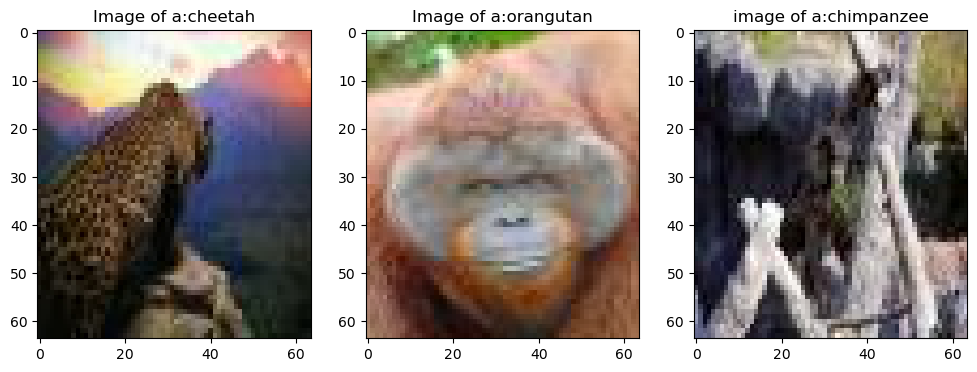

In [5]:
class CustomDataset(Dataset): 
    def __init__(self, data, labels, transform=None):
        # we pass data and labels when we initialize the class
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # function that outputs length of dataset
        return len(self.data)

    def __getitem__(self, idx):
        # function that outputs data item with index idx
        # return data, label
        data_idx = self.data[idx]
        label = self.labels[idx].type(torch.LongTensor) # label must be output as datatype=Long (also known as int64)
        if self.transform:
            data_idx = self.transform(data_idx)
            
        return data_idx, label

class AddGaussianNoise(object):
    def __init__(self, mean=0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.std + self.mean
        return tensor + noise
    

#Define the transforms right before calling dataset class:
mean_x = X_train_tensor.mean(dim=(0,2,3))
std_x = X_train_tensor.std(dim=(0,2,3))

#This is the final version combined for image augmentation:
transforms_augment = v2.Compose([
    #v2.Normalize(mean=mean_x, std=std_x),  #Normalize(mean=0.5, std=0.5) #Normalize to [-1,1] dont use normalize!!!
    v2.RandomResizedCrop(size=(64, 64), scale=(0.8, 1),antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    #v2.RandomRotation(degrees=20),
    AddGaussianNoise(mean=0, std=0.01),
])

train_dataset_class = CustomDataset(X_train_tensor, Y_train_tensor, transforms_augment)
# apply CustomDataset() to test dataset
test_dataset_class = CustomDataset(X_test_tensor,Y_test_tensor)

# we pass the dataset as an argument to DataLoader -> automatic batching, sampling, shuffling etc.
batch_size = 64

# create data loaders
train_dataloader = DataLoader(train_dataset_class, batch_size = batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset_class, batch_size = batch_size,shuffle=True)



#Select first random batch of images:
i = 0
for x,y in test_dataloader:
    labels = y
    images = x
    i+=1
    if i == 1:
        break



print(images.shape)
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title("Image of a:" +str(label_meaning[labels[0]]))
plt.imshow(images[0].permute(1,2,0).numpy(), aspect="auto")
plt.subplot(132)
plt.title("Image of a:" +str(label_meaning[labels[1]]))
plt.imshow(images[1].permute(1,2,0).numpy(), aspect="auto")
plt.subplot(133)
plt.title("image of a:" +str(label_meaning[labels[2]]))
plt.imshow(images[2].permute(1,2,0).numpy(), aspect="auto")


        

In [6]:
## Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


model = torchvision.models.resnet18(weights=None)    #import resnet without weights
model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.35, training=m.training))
model = model.to(device)
print(model)

loss_fn = nn.CrossEntropyLoss() # we use Cross Entropy as loss
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2) # The optimizer is Adam

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {pytorch_total_params}")


Using cuda device
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReL

## Training the model


In [8]:
# define the train and test loss accumulation
train_loss_dnn = []
train_acc_dnn = []
test_loss_dnn = []
test_acc_dnn = []

In [9]:
# define training function: make predicition on data set batch,
# backpropagate the error and adjust model parameters

def train(dataloader, model, loss_fn, optimizer, train_loss, train_acc):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    model.train()
    running_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # X = X.permute(0, 3, 1, 2) --> Merijn: "no longer needed. This is applied in subsample_and_to_tensor() function!"
        X, y = X.to(device), y.to(device)

    
            

        #compute prediction error
        pred = model(X)
        loss = loss_fn(pred,y)

        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # collect the accuracy:
        running_loss += loss.item()
        correct += (pred.argmax(1)==y).type(torch.float).sum().item()

        if batch % 25==0:
            loss,current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    running_loss /= num_batches
    correct /= size

    train_acc.append(correct)
    train_loss.append(running_loss)

#check performance against the test data set
def test(dataloader,model,loss_fn,test_loss, test_acc):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    running_loss, correct = 0, 0
    with torch.no_grad():
        for X,y in dataloader:
            #X = X.permute(0, 3, 1, 2) --> Merijn: "no longer needed. This is applied in subsample_and_to_tensor() function!"
            X,y = X.to(device), y.to(device)
            pred = model(X)
            running_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    running_loss /= num_batches
    correct /= size

    test_acc.append(correct)
    test_loss.append(running_loss)
    print(f"Test Error: \n Accuracy {(100*correct):>0.1f}%, Avg loss:{running_loss:>8f}\n")

In [10]:

epochs = 50
lr_array = np.linspace(1e-2,2e-3, epochs) #make sure to change this when extending epochs!!!

for t in range(epochs):
    print(f"Epoch {t+1}\n -------------------")
    optimizer = torch.optim.Adam(model.parameters(),lr=lr_array[t]) # The optimizer is Adam
    #train(train_dataloader,model,loss_fn,optimizer, train_loss_dnn, train_acc_dnn)
    #test(test_dataloader,model,loss_fn, test_loss_dnn, test_acc_dnn)
print("Done!")


Epoch 1
 -------------------
Epoch 2
 -------------------
Epoch 3
 -------------------
Epoch 4
 -------------------
Epoch 5
 -------------------
Epoch 6
 -------------------
Epoch 7
 -------------------
Epoch 8
 -------------------
Epoch 9
 -------------------
Epoch 10
 -------------------
Epoch 11
 -------------------
Epoch 12
 -------------------
Epoch 13
 -------------------
Epoch 14
 -------------------
Epoch 15
 -------------------
Epoch 16
 -------------------
Epoch 17
 -------------------
Epoch 18
 -------------------
Epoch 19
 -------------------
Epoch 20
 -------------------
Epoch 21
 -------------------
Epoch 22
 -------------------
Epoch 23
 -------------------
Epoch 24
 -------------------
Epoch 25
 -------------------
Epoch 26
 -------------------
Epoch 27
 -------------------
Epoch 28
 -------------------
Epoch 29
 -------------------
Epoch 30
 -------------------
Epoch 31
 -------------------
Epoch 32
 -------------------
Epoch 33
 -------------------
Epoch 34
 ---------

In [11]:
def create_acc_loss_graph(train_acc,train_loss, test_acc, test_loss):
    fig, axes = plt.subplots(ncols=2, nrows=1, dpi=300)
    fig.set_size_inches(9, 3)
    ax1, ax2 = axes[0], axes[1]

    ax1.plot(train_acc,'-o',label="train", markersize=4)
    ax1.plot(test_acc,'--+',label="test", markersize=4)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc=3)

    ax2.plot(train_loss,'-o',label="train", markersize=4)
    ax2.plot(test_loss,'--+',label=" test", markersize=4)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc=1)

    #plot parameters
    ax1.set_ylim(0, np.max([np.max(train_acc),np.max(test_acc)])+0.1)
    ax2.set_ylim(-0.1, np.max([np.max(train_loss),np.max(test_loss)])+0.1)
    ax1.grid(True, which='both',linewidth=0.1)
    ax2.grid(True, which='both',linewidth=0.1)
    plt.tight_layout()
    plt.show()

In [12]:
#create_acc_loss_graph(train_acc_dnn,train_loss_dnn, test_acc_dnn, test_loss_dnn)
#plt.savefig('resnet18_training_lr_1e-2_to_2e-3_optimal_augmentation.jpg')

In [13]:
#torch.save(model.state_dict(), "Model params/trained_params")

In [14]:

model.load_state_dict(torch.load("Model params/trained_params"))   #this should load the model, please try it on one of your pcs.
                                                     # it might not work as the variables are trained on CUDA when trying to load to a cpu. for that, look here how to change parameter type
                                                    # https://pytorch.org/tutorials/recipes/recipes/save_load_across_devices.html
test(test_dataloader,model,loss_fn, test_loss_dnn, test_acc_dnn)

Test Error: 
 Accuracy 70.1%, Avg loss:0.979907



In [15]:
#LOAD using CPU:
#model.load_state_dict(torch.load("Model params/trained_params", map_location=torch.device('cpu')))


In [16]:
for param in model.parameters():
    #print(param)        # The tensor itself
    print(param.shape)  # Its shape


torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
t

In [17]:
!pip install tensorly

In [18]:
import torch
import torch.nn as nn
# Import TensorLy and set the PyTorch backend
import tensorly as tl
tl.set_backend('pytorch') 
from tensorly.decomposition import tensor_train

# ==========================================================
# TT-SVD decomposition (using TensorLy)
# ==========================================================
def tt_svd(tensor, max_rank=None, eps=None):
    """
    Perform Tensor Train decomposition using TT-SVD via the TensorLy library.
    
    Args:
        tensor (torch.Tensor): Input tensor.
        max_rank (int): Maximum TT rank (optional).
        eps (float): Relative error tolerance (optional).
        
    Returns:
        cores (list[torch.Tensor]): List of TT cores (PyTorch tensors).
    """
    
    # TensorLy uses 'rank' parameter to specify the maximum rank.
    # It should be an integer or a list of integers.
    # If max_rank is None, use a default high rank.
    rank = max_rank if max_rank is not None else tensor.shape[0] 
    
    # TensorLy parameters:
    # rank: The maximum rank to use (r1, r2, ... rN-1)
    # n_svd: The method to compute SVD (standard is 'svd')
    # epsilon: The relative error tolerance (used if max_rank is None)
    
    # Note: TensorLy's 'tensor_train' (TT-SVD) function returns the cores directly.
    cores_tl = tensor_train(
        tensor,
        rank=rank,
        svd='truncated_svd' # Use standard torch.linalg.svd
    )
    
    # The cores returned by TensorLy are already PyTorch tensors,
    # as we set the backend to 'pytorch' at the beginning.
    return cores_tl


# ==========================================================
# TT Reconstruction
# ==========================================================
def tt_reconstruct(cores):
    """
    Reconstruct tensor from TT cores.
    ...
    """
    X = cores[0]
    for k in range(1, len(cores)):
        dims_x = len(X.shape)
        X = torch.tensordot(X, cores[k], dims=([dims_x - 1], [0]))
        
    return X.squeeze()


# ... (The rest of your code: compress_model_tt, reconstruct_model_from_tt, etc. are placed here)
# Since you were already using the PyTorch backend for your custom tt_svd,
# these functions should work seamlessly with the TensorLy output.

# ==========================================================
# Model compression
# ==========================================================
def compress_model_tt(model, max_rank=None, eps=None):
    """
    Compress each parameter tensor in a model using TT-SVD.
    ...
    """
    tt_params = {}
    with torch.no_grad():
        for name, param in model.named_parameters():
            if param.ndim < 2:
                # Skip 1D tensors (e.g. biases)
                tt_params[name] = ([param.clone()], param.shape)
                continue

            # call ttsvd
            cores = tt_svd(param.data, max_rank=max_rank, eps=eps) 
            tt_params[name] = (cores, param.shape)

    return tt_params




# ==========================================================
# Model reconstruction
# ==========================================================
def reconstruct_model_from_tt(model, tt_params):
    """
    Reconstruct model weights from TT cores, preserving shapes.
    Args:
        model (torch.nn.Module): Model to fill in.
        tt_params (dict): Output of compress_model_tt.
    """
    with torch.no_grad():
        for name, param in model.named_parameters():
            cores, shape = tt_params[name]
            if len(cores) == 1 and cores[0].shape == shape:
                param.copy_(cores[0])
            else:
                reconstructed = tt_reconstruct(cores).reshape(shape)
                param.copy_(reconstructed)


# ==========================================================
# Save/Load using torch.save
# ==========================================================
def save_tt_params(tt_params, filename):
    # Convert TT cores into plain tensors and shapes
    serializable = {}
    for name, (cores, shape) in tt_params.items():
        serializable[name] = {
            "cores": [core.cpu() for core in cores],
            "shape": shape
        }
    torch.save(serializable, filename)


def load_tt_params(filename, device=None):
    data = torch.load(filename, map_location=device or "cpu")
    tt_params = {}
    for name, entry in data.items():
        cores = [core.to(device or "cpu") for core in entry["cores"]]
        shape = entry["shape"]
        tt_params[name] = (cores, shape)
    return tt_params


In [19]:
#orig model
model.load_state_dict(torch.load("Model params/trained_params"))   #this should load the model, please try it on one of your pcs.
test(test_dataloader,model,loss_fn, test_loss_dnn, test_acc_dnn)


#compress
tt_params = compress_model_tt(model, max_rank = 50)

#save/load
save_tt_params(tt_params, "Model params/compressed_model_in_tt_form.pt")
tt_loaded = load_tt_params("Model params/compressed_model_in_tt_form.pt")


#reconstruct the full weights into your model
reconstruct_model_from_tt(model, tt_loaded)
test(test_dataloader,model,loss_fn, test_loss_dnn, test_acc_dnn)

#compression ratio:
comp_ratio = round(os.path.getsize("Model params/trained_params") / os.path.getsize("Model params/compressed_model_in_tt_form.pt"), 2)
print("Compression ratio is:", comp_ratio)

Test Error: 
 Accuracy 70.1%, Avg loss:0.978547

Test Error: 
 Accuracy 65.7%, Avg loss:1.205855

Compression ratio is: 6.18


In [20]:
#OLD VERSION WITH MANUAL TT-SVD ALG

import torch
import torch.nn as nn

# ==========================================================
# TT-SVD decomposition
# ==========================================================
def tt_svd(tensor, max_rank=None, eps=None):
    """
    Perform Tensor Train decomposition using TT-SVD.
    Args:
        tensor (torch.Tensor): Input tensor.
        max_rank (int): Maximum TT rank (optional).
        eps (float): Relative error tolerance (optional).
    Returns:
        cores (list[torch.Tensor]): List of TT cores.
    """
    original_shape = list(tensor.shape)
    tensor = tensor.clone().detach()
    N = len(original_shape)
    ranks = [1]
    cores = []
    unfolding = tensor

    for k in range(N - 1):
        unfolding = unfolding.reshape(ranks[-1] * original_shape[k], -1)
        U, S, Vt = torch.linalg.svd(unfolding, full_matrices=False)

        # Rank truncation
        if eps is not None:
            cumulative_energy = torch.cumsum(S ** 2, dim=0)
            energy_total = cumulative_energy[-1]
            r = torch.sum(cumulative_energy < (1 - eps ** 2) * energy_total).item() + 1
            r = int(r)
        elif max_rank is not None:
            r = min(max_rank, S.numel())
        else:
            r = S.numel()

        U = U[:, :r]
        S = S[:r]
        Vt = Vt[:r, :]

        core = U.reshape(ranks[-1], original_shape[k], r)
        cores.append(core)

        unfolding = torch.mm(torch.diag(S), Vt)
        ranks.append(r)

    cores.append(unfolding.reshape(ranks[-1], original_shape[-1], 1))
    return cores


# ==========================================================
# TT Reconstruction (preserves original shape)
# ==========================================================
def tt_reconstruct(cores):
    """
    Reconstruct tensor from TT cores.
    Args:
        cores (list[torch.Tensor]): List of TT cores.
    Returns:
        torch.Tensor: Reconstructed tensor.
    """
    X = cores[0]
    for k in range(1, len(cores)):
        X = torch.tensordot(X, cores[k], dims=([len(X.shape) - 1], [0]))
    return X.squeeze()


# ==========================================================
# Model compression
# ==========================================================
def compress_model_tt(model, max_rank=None, eps=None):
    """
    Compress each parameter tensor in a model using TT-SVD.
    Args:
        model (torch.nn.Module): The model to compress.
        max_rank (int): Maximum TT rank.
        eps (float): Relative approximation tolerance.
    Returns:
        dict: Mapping from parameter names to (cores, original_shape).
    """
    tt_params = {}
    with torch.no_grad():
        for name, param in model.named_parameters():
            if param.ndim < 2:
                # Skip 1D tensors (e.g. biases)
                tt_params[name] = ([param.clone()], param.shape)
                continue

            cores = tt_svd(param.data, max_rank=max_rank, eps=eps)
            tt_params[name] = (cores, param.shape)

    return tt_params


# ==========================================================
# Model reconstruction
# ==========================================================
def reconstruct_model_from_tt(model, tt_params):
    """
    Reconstruct model weights from TT cores, preserving shapes.
    Args:
        model (torch.nn.Module): Model to fill in.
        tt_params (dict): Output of compress_model_tt.
    """
    with torch.no_grad():
        for name, param in model.named_parameters():
            cores, shape = tt_params[name]
            if len(cores) == 1 and cores[0].shape == shape:
                param.copy_(cores[0])
            else:
                reconstructed = tt_reconstruct(cores).reshape(shape)
                param.copy_(reconstructed)


# ==========================================================
# Save/Load using torch.save (no pickle)
# ==========================================================
def save_tt_params(tt_params, filename):
    # Convert TT cores into plain tensors and shapes
    serializable = {}
    for name, (cores, shape) in tt_params.items():
        serializable[name] = {
            "cores": [core.cpu() for core in cores],
            "shape": shape
        }
    torch.save(serializable, filename)


def load_tt_params(filename, device=None):
    data = torch.load(filename, map_location=device or "cpu")
    tt_params = {}
    for name, entry in data.items():
        cores = [core.to(device or "cpu") for core in entry["cores"]]
        shape = entry["shape"]
        tt_params[name] = (cores, shape)
    return tt_params

